# Train and compare two Wide and Deep models on the data snippet

In [1]:
import pandas as pd
import numpy as np
file_path = "/content/drive/MyDrive/Fellowship.AI/P1_bandit/data_snippet.csv"
df = pd.read_csv(file_path)
df.head()

,riid,opened,rev_3dv2,unsub,campaign_type,retention_score,recency_score,frequency_score
0,242697842,1,75.00,0,Dedicated,14.000000,1.637422,31
1,275469002,1,75.00,0,Dedicated,2.800000,0.000000,0
2,4319542,1,19.98,0,Dedicated,1.000000,0.084239,4
3,166170102,1,19.98,0,Dedicated,0.756757,0.010870,1
4,6998482,1,150.00,0,Dedicated,28.000000,1.845885,18


In [2]:
print("Total number of data in the data snippet: {}.".format(len(df)))

Total number of data in the data snippet: 6240490.


In [3]:
# randomly chose a subset with size num_data
num_data = 100000
indices = np.random.choice(len(df),size=num_data)
df_subset = df.iloc[indices]

In [4]:
# create a vocabulary mapping each riid to an index 
vocab = {riid:i for i, riid in enumerate(df_subset.riid.unique())}
print("{} unique users".format(len(vocab)))

87864 unique users


Archetecture of the Wide and Deep Model

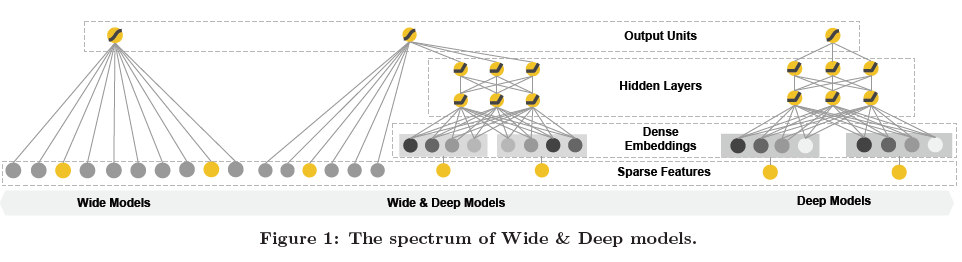

## Model 1 (class W_D): user_id as input of the DEEP part

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from collections import OrderedDict
import numpy as np
import time

# this model use user_id as input of the Deep part
class W_D(nn.Module):
    def __init__(self,         
                 wide_in_dim=3,
                 deep_in_dim=3, 
                 action_dim=3, 
                 num_embedding=100, 
                 embed_dim=16, 
                 deep_neurons=[32, 16], 
                 activation=nn.ReLU()):
        
        super(W_D, self).__init__()
        self.wide_in_dim = wide_in_dim
        self.context_dim = wide_in_dim + deep_in_dim
        self.z_dim = wide_in_dim + deep_neurons[-1]
        self.action_dim = action_dim
        self.activation = activation
        
        self.embedding = nn.Embedding(num_embedding, embed_dim)
        deep_dict = OrderedDict([])
        in_features = deep_in_dim -1 + embed_dim 
        for i, out_features in enumerate(deep_neurons):
            deep_dict[f"fc{i}"] = nn.Linear(in_features, out_features)
            deep_dict[f"activation{i}"] = activation
            in_features = out_features

        self.deep = nn.Sequential(deep_dict)
        # define the final layer
        self.lastlayer = nn.Linear(self.z_dim, self.action_dim)
        
    def forward(self, x):
        z = self.get_z(x)
        out = self.lastlayer(z)
        return out
    
    def get_z(self, x):

        w_in = x[:, :self.wide_in_dim]
        d_in = x[:, self.wide_in_dim:]
        
        embed_in = d_in[:,0].long()
        embed_out = self.embedding(embed_in)
        nn_in = torch.cat((embed_out, d_in[:,1:]), dim=1)
        d_out = self.deep(nn_in)
        z = torch.cat((w_in, d_out),dim=1)
        return z


In [6]:
user_ids = df_subset.riid.apply(lambda x:vocab[x])
c_t = pd.get_dummies(df_subset.campaign_type)
# prepare the context for model 1
datasource = pd.DataFrame()
datasource['user_ids'] = user_ids
datasource = pd.concat((c_t, datasource),axis=1)
datasource[["retention_score",	"recency_score",	"frequency_score"]] = df_subset[["retention_score",	"recency_score",	"frequency_score"]]

In [7]:
# prepare the reward vectors for model 1
rewardsource = pd.DataFrame()
rewardsource["reward_send"] = df_subset.opened * 1.2 - 0.2 + (df_subset.rev_3dv2 > 0) + df_subset.rev_3dv2/75.0 - 5.0*df_subset.unsub
rewardsource["reward_not_send"] = -rewardsource["reward_send"]

In [8]:
# optimal actions considerinng the reward vectors defined above
opt_a = (rewardsource['reward_send'] < 0).astype(int)

In [9]:
# A custumized class of torch dataset for the training
class Mydataset(torch.utils.data.Dataset):
    def __init__(self, contexts, reward_vectors, optimal_actions):
      self.contexts = np.array(contexts)
      self.reward_vectors = np.array(reward_vectors)
      self.optimal_actions = np.array(optimal_actions)

    def __getitem__(self, index):
        context = self.contexts[index]
        reward_vector = self.reward_vectors[index]
        optimal_action = self.optimal_actions[index]
        return context, reward_vector, optimal_action

    def __len__(self):
        return self.contexts.shape[0]

In [10]:
split = 0.7
batch_size = 1024
#define datasets and dataloaders for training of model 1
dataset_train = Mydataset(datasource.iloc[:int(num_data * split)],rewardsource.iloc[:int(num_data * split)], opt_a.iloc[:int(num_data * split)])
dataset_valid = Mydataset(datasource.iloc[int(num_data * split):],rewardsource.iloc[int(num_data * split):], opt_a.iloc[int(num_data * split):])
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=True)

In [11]:
# A function to train and valid the model for each epoch, output the losses and accuracies.
def train(device, model, optimizer, loss_func, dataloader_train, dataloader_valid, num_epoch):
    start_time = time.time()
    accuracy_train = []
    loss_record_train = []
    accuracy_valid = []
    loss_record_valid = []
    s_time = start_time
    for i in range(num_epoch):
        model.train()
        corrects = 0.0
        train_loss = 0.0
        for c_train, r_train, opt_a_train in dataloader_train:
            c_train = c_train.float().to(device)
            r_train = r_train.float().to(device)
            opt_a_train = opt_a_train.long().to(device)
            pred_r_train = model(c_train)
            loss = loss_func(pred_r_train, r_train)
            pred_a_train = torch.argmax(pred_r_train, dim=1)
            corrects += torch.sum(pred_a_train==opt_a_train).item()
            train_loss += loss.item() * c_train.shape[0]

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        accuracy_train.append(corrects/len(dataloader_train.dataset))
        loss_record_train.append(train_loss/len(dataloader_train.dataset))

        model.eval()
        corrects = 0.0
        valid_loss = 0.0
        for c_valid, r_valid, opt_a_valid in dataloader_valid:
            c_valid = c_valid.float().to(device)
            r_valid = r_valid.float().to(device)
            opt_a_valid = opt_a_valid.long().to(device)
            pred_r_valid = model(c_valid)
            loss = loss_func(pred_r_valid, r_valid)
            pred_a_valid = torch.argmax(pred_r_valid, dim=1)
            corrects += torch.sum(pred_a_valid==opt_a_valid).item()
            valid_loss += loss.item() * c_valid.shape[0]

        accuracy_valid.append(corrects/len(dataloader_valid.dataset))
        loss_record_valid.append(valid_loss/len(dataloader_valid.dataset))

        print("Epoch:{:>4}\t Training Loss: {:6.3f}\t Valid Loss: {:6.3f}\t Training Accuracy: {:.3f}\t Valid Accuracy: {:.3f}\t time used: {:.3f} sec".format(i+1, loss_record_train[i], loss_record_valid[i], accuracy_train[i], accuracy_valid[i], time.time()-s_time))
        s_time = time.time()
    end_time = time.time()
    total_time = end_time - start_time
    print("total time used: {} hrs {} min {:.3f} sec".format(int(total_time//3600), int((total_time%3600)//60), total_time%60))


In [12]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print("train on device: ", device)
model = W_D(wide_in_dim=11, deep_in_dim=4, action_dim=2, num_embedding=len(vocab), embed_dim=64, deep_neurons=[128, 64]).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.MSELoss()
num_epoch = 20
train(device, model, optimizer, loss_func, dataloader_train, dataloader_valid, num_epoch)

train on device:  cuda:0
Epoch:   1	 Training Loss:  0.377	 Valid Loss:  0.342	 Training Accuracy: 0.673	 Valid Accuracy: 0.684	 time used: 1.055 sec
Epoch:   2	 Training Loss:  0.344	 Valid Loss:  0.338	 Training Accuracy: 0.701	 Valid Accuracy: 0.698	 time used: 1.062 sec
Epoch:   3	 Training Loss:  0.337	 Valid Loss:  0.337	 Training Accuracy: 0.709	 Valid Accuracy: 0.699	 time used: 1.061 sec
Epoch:   4	 Training Loss:  0.330	 Valid Loss:  0.338	 Training Accuracy: 0.714	 Valid Accuracy: 0.696	 time used: 1.076 sec
Epoch:   5	 Training Loss:  0.320	 Valid Loss:  0.343	 Training Accuracy: 0.723	 Valid Accuracy: 0.686	 time used: 1.046 sec
Epoch:   6	 Training Loss:  0.307	 Valid Loss:  0.351	 Training Accuracy: 0.730	 Valid Accuracy: 0.687	 time used: 1.039 sec
Epoch:   7	 Training Loss:  0.291	 Valid Loss:  0.363	 Training Accuracy: 0.746	 Valid Accuracy: 0.692	 time used: 1.050 sec
Epoch:   8	 Training Loss:  0.272	 Valid Loss:  0.372	 Training Accuracy: 0.764	 Valid Accuracy: 0.6

if always send email the accurcy:

In [13]:
(rewardsource["reward_send"]>0).sum()/len(rewardsource)

0.59637

## Model_2 (class W_D_2): user_id as input of WIDE part

In [14]:
# user_id in wide
class W_D_2(nn.Module):
    def __init__(self,         
                 wide_in_dim=3,
                 deep_in_dim=3, 
                 action_dim=3, 
                 num_embedding=100, 
                 embed_dim=16, 
                 deep_neurons=[32, 16], 
                 activation=nn.ReLU()):
        
        super(W_D_2, self).__init__()
        self.wide_in_dim = wide_in_dim
        self.context_dim = wide_in_dim + deep_in_dim
        self.z_dim = embed_dim + deep_neurons[-1]
        self.action_dim = action_dim
        self.activation = activation
        
        self.embedding = nn.Embedding(num_embedding, embed_dim)

        deep_dict = OrderedDict([])
        in_features = deep_in_dim 
        for i, out_features in enumerate(deep_neurons):
            deep_dict[f"fc{i}"] = nn.Linear(in_features, out_features)
            deep_dict[f"activation{i}"] = activation
            in_features = out_features

        self.deep = nn.Sequential(deep_dict)
        # define the final layer
        self.lastlayer = nn.Linear(self.z_dim, self.action_dim)
        
    def forward(self, x):
        z = self.get_z(x)
        out = self.lastlayer(z)
        return out
    
    def get_z(self, x):

        w_in = x[:, :self.wide_in_dim]
        d_in = x[:, self.wide_in_dim:]
        
        embed_in = w_in[:,0].long()
        embed_out = self.embedding(embed_in)
        nn_in = d_in
        d_out = self.deep(nn_in)
        z = torch.cat((embed_out, d_out),dim=1)
        return z

In [15]:
datasource_2 = pd.DataFrame()
datasource_2['user_ids'] = user_ids
datasource_2 = pd.concat((datasource_2, c_t),axis=1)
datasource_2[["retention_score",	"recency_score",	"frequency_score"]] = df_subset[["retention_score",	"recency_score",	"frequency_score"]]

In [16]:
datasource_2

,user_ids,Brand,Collection,Core,Dedicated,Innovation Spotlight,New Arrivals,Other,Product Spotlight,Replen,Tops,Trend,retention_score,recency_score,frequency_score
5914695,0,0,0,0,0,0,0,0,0,0,0,1,28.000000,1.547943,13
2119291,1,1,0,0,0,0,0,0,0,0,0,0,28.000000,1.772127,28
3439182,2,0,0,0,1,0,0,0,0,0,0,0,14.000000,1.635287,8
4883836,3,0,0,0,0,0,0,0,0,0,0,1,28.000000,3.230590,30
4495739,4,1,0,0,0,0,0,0,0,0,0,0,1.217391,0.497283,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5586953,87861,0,0,0,0,0,1,0,0,0,0,0,5.600000,0.195846,4
2953364,87862,0,0,0,1,0,0,0,0,0,0,0,28.000000,4.984084,47
3056985,25482,0,0,0,0,1,0,0,0,0,0,0,14.000000,2.091809,35
2154817,87863,0,0,0,0,0,0,0,1,0,0,0,28.000000,4.742624,70


In [17]:
dataset_train_2 = Mydataset(datasource_2.iloc[:int(num_data * split)],rewardsource.iloc[:int(num_data * split)], opt_a.iloc[:int(num_data * split)])
dataset_valid_2 = Mydataset(datasource_2.iloc[int(num_data * split):],rewardsource.iloc[int(num_data * split):], opt_a.iloc[int(num_data * split):])
dataloader_train_2 = torch.utils.data.DataLoader(dataset_train_2, batch_size=batch_size, shuffle=True)
dataloader_valid_2 = torch.utils.data.DataLoader(dataset_valid_2, batch_size=batch_size, shuffle=True)

In [18]:
model_2 = W_D_2(wide_in_dim=1, deep_in_dim=14, action_dim=2, num_embedding=len(vocab), embed_dim=64, deep_neurons=[128, 64]).to(device)
optimizer_2 = optim.Adam(model_2.parameters(), lr=0.001)
loss_func = nn.MSELoss()
num_epoch = 20
train(device, model_2, optimizer_2, loss_func, dataloader_train_2, dataloader_valid_2, num_epoch)

Epoch:   1	 Training Loss:  0.438	 Valid Loss:  0.354	 Training Accuracy: 0.691	 Valid Accuracy: 0.694	 time used: 1.051 sec
Epoch:   2	 Training Loss:  0.349	 Valid Loss:  0.341	 Training Accuracy: 0.696	 Valid Accuracy: 0.695	 time used: 1.001 sec
Epoch:   3	 Training Loss:  0.341	 Valid Loss:  0.334	 Training Accuracy: 0.700	 Valid Accuracy: 0.697	 time used: 1.048 sec
Epoch:   4	 Training Loss:  0.337	 Valid Loss:  0.333	 Training Accuracy: 0.705	 Valid Accuracy: 0.696	 time used: 1.042 sec
Epoch:   5	 Training Loss:  0.334	 Valid Loss:  0.335	 Training Accuracy: 0.706	 Valid Accuracy: 0.699	 time used: 1.046 sec
Epoch:   6	 Training Loss:  0.331	 Valid Loss:  0.341	 Training Accuracy: 0.711	 Valid Accuracy: 0.691	 time used: 1.042 sec
Epoch:   7	 Training Loss:  0.326	 Valid Loss:  0.343	 Training Accuracy: 0.711	 Valid Accuracy: 0.692	 time used: 1.069 sec
Epoch:   8	 Training Loss:  0.318	 Valid Loss:  0.349	 Training Accuracy: 0.718	 Valid Accuracy: 0.685	 time used: 1.039 sec
